---
title: AERO 417 Project 1
---

In [27]:
import numpy as np
from scipy.optimize import fsolve
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sy

## Constant Mean Diameter (CMD)

In [116]:
# Input Constraints
takeoff_thrust = 12000
pressure_ambient = 1.01
temperature_ambient = 288

P_compressor = 4.15
m_dot = 20
turbine_inlet_temperature = 1100

Cp = 1005
gamma = 1.4
R = 287

compressor_polytropic_efficiency = 0.9
n_compressor = -1/(1/compressor_polytropic_efficiency*(gamma-1)/gamma-1)

# Design Variables
N = 250
U_tip = 355.3
C_axial = 150
rr_rt = 0.5

### Compressor Geometry

In [119]:
T01 = temperature_ambient
P01 = pressure_ambient
C1 = C_axial

T1 = T01-C1**2/2/Cp
P1 = P01*(T1/T01)**(gamma/(gamma-1))
rho1 = P1/R/T1*100000

inlet_radius_tip = (m_dot/(np.pi*rho1*C1)/(1-rr_rt**2))**0.5
inlet_radius_root = rr_rt*inlet_radius_tip
inlet_radius_mean = (inlet_radius_tip+inlet_radius_root)/2

V1_tangent = (U_tip**2+C_axial**2)**0.5
a1 = (gamma*R*T1)**0.5
M1 = V1_tangent/a1

C2 = C1
T02 = T01*(P_compressor)**((n_compressor-1)/n_compressor)
P02 = P_compressor*P01
T2 = T02-C2**2/2/Cp
P2 = P02*(T2/T02)**(gamma/(gamma-1))
rho2 = P2/R/T2*100000
A2 = m_dot/rho2/C2

outlet_radius_mean = inlet_radius_mean
h = A2/2/np.pi/outlet_radius_mean
outlet_radius_tip = outlet_radius_mean+h/2
outlet_radius_root = outlet_radius_mean-h/2

print("Geometry:")
print("Inlet")
print("Tip-",inlet_radius_tip)
print("Root-",inlet_radius_root)
print("Mean-",inlet_radius_mean)
print("Outlet")
print("Tip-",outlet_radius_tip)
print("Root-",outlet_radius_root)
print("Mean-",outlet_radius_mean)

U_mean = 2*np.pi*N*outlet_radius_mean
Beta1 = np.arctan(U_mean/C_axial)
V1 = C_axial/np.cos(Beta1)
V2 = 0.72*V1
Beta2 = np.arccos(C_axial/V2)

ideal_temperature_rise = U_mean*C_axial*(np.tan(Beta1)-np.tan(Beta2))/Cp
num_stages = int(np.ceil((T2-T1)/ideal_temperature_rise)+1)

Geometry:
Inlet
Tip- 0.22613177899925122
Root- 0.11306588949962561
Mean- 0.16959883424943842
Outlet
Tip- 0.1902343302069359
Root- 0.14896333829194094
Mean- 0.16959883424943842


In [147]:
# Calculate the mean temperature rise per stage
mean_temp_rise = (T2 - T1) / num_stages

# Ensure temperature rises are rounded to multiples of 5 for consistency
min_temp_rise = mean_temp_rise - (mean_temp_rise % np.ceil(mean_temp_rise / 5))
max_temp_rise = ((T2 - T1) - 2 * min_temp_rise) / (num_stages - 2)

# Create a list of temperature rises for each stage
temp_rise = [min_temp_rise] + [max_temp_rise] * (num_stages - 2) + [min_temp_rise]

# Calculate work done per stage, decreasing from 0.98 to 0.83
work_done = np.clip(0.98 - np.arange(num_stages) * 0.05, 0.83, None)

# Initialize swirl velocities
C1_swirl_mean = [0]
swirl_change = Cp * temp_rise[0] / (work_done[0] * U_mean)
C2_swirl_mean = [C1_swirl_mean[0] + swirl_change]

# Calculate flow angles and De Haller factor for the first stage
Beta1_mean = [np.arctan(U_mean / C_axial)]
Alpha1_mean = [np.arctan(C1_swirl_mean[0] / C_axial)]
Beta2_mean = [np.arctan((U_mean - C2_swirl_mean[0]) / C_axial)]
Alpha2_mean = [np.arctan(C2_swirl_mean[0] / C_axial)]

De_Haller_mean = [np.cos(Beta1_mean[0]) / np.cos(Beta2_mean[0])]

# Initialize pressure ratios and total pressures/temperatures for the first stage
P_ratio = [(1 + compressor_polytropic_efficiency * temp_rise[0] / T01) ** (gamma / (gamma - 1))]
Inlet_P0 = [P01]
Outlet_P0 = [P_ratio[0] * P01]
Inlet_T0 = [T01]
Outlet_T0 = [T01 + temp_rise[0]]

T2 = Outlet_T0[-1]-C_axial**2/2/Cp
P2 = Outlet_P0[-1]*(T2/Outlet_T0[-1])**(gamma/(gamma-1))
rho2 = P2/R/T2*100000
A2 = m_dot/rho2/C2

outlet_radius_mean = inlet_radius_mean
h = A2/2/np.pi/outlet_radius_mean
tips = [(outlet_radius_mean+h/2+inlet_radius_tip)/2,outlet_radius_mean+h/2]
C1_swirl_tip = [C1_swirl_mean[0]*outlet_radius_mean/tips[0]]
C2_swirl_tip = [C2_swirl_mean[0]*outlet_radius_mean/tips[1]]

Beta1_tip = [np.arctan(2*np.pi*N*tips[0] / C_axial)]
Alpha1_tip = [np.arctan(C1_swirl_tip[0] / C_axial)]
Beta2_tip = [np.arctan((2*np.pi*N*tips[1] - C2_swirl_tip[0]) / C_axial)]
Alpha2_tip = [np.arctan(C2_swirl_tip[0] / C_axial)]

roots = [(outlet_radius_mean-h/2+inlet_radius_root)/2,outlet_radius_mean-h/2]
C1_swirl_root = [C1_swirl_mean[0]*outlet_radius_mean/roots[0]]
C2_swirl_root = [C2_swirl_mean[0]*outlet_radius_mean/roots[1]]

Beta1_root = [np.arctan(2*np.pi*N*roots[0] / C_axial)]
Alpha1_root = [np.arctan(C1_swirl_root[0] / C_axial)]
Beta2_root = [np.arctan((2*np.pi*N*roots[1] - C2_swirl_root[0]) / C_axial)]
Alpha2_root = [np.arctan(C2_swirl_root[0] / C_axial)]

# Initialize lambda values for each stage (Lambda[0] for first, 0.5 for others)
Lambda = [1 - (C2_swirl_mean[0] + C1_swirl_mean[0]) / (2 * U_mean), 0.7] + [0.5] * (num_stages - 2)

# Define the system of equations for the flow angles
def beta_equations(flow_angles, stage_idx):
    Beta1, Beta2 = flow_angles
    return [
        temp_rise[stage_idx] * Cp / (work_done[stage_idx] * U_mean * C_axial) - (np.tan(Beta1) - np.tan(Beta2)),
        Lambda[stage_idx] / C_axial * 2 * U_mean - (np.tan(Beta1) + np.tan(Beta2))
    ]

# Solve for each stage (starting from stage 1)
for stage_idx in range(1, num_stages):
    # Solve the system of equations for flow angles Beta1, Beta2 for the current stage
    b1, b2 = fsolve(beta_equations, [1, 1], args=(stage_idx,))
    Beta1_mean.append(b1)
    Beta2_mean.append(b2)
    
    # Calculate Alpha1 and Alpha2 based on the flow angles
    Alpha1_mean.append(np.arctan(U_mean / C_axial - np.tan(Beta1_mean[-1])))
    Alpha2_mean.append(np.arctan(U_mean / C_axial - np.tan(Beta2_mean[-1])))
    
    # Update swirl velocities for the current stage
    C1_swirl_mean.append(C_axial * np.tan(Alpha1_mean[-1]))
    C2_swirl_mean.append(C_axial * np.tan(Alpha2_mean[-1]))
    
    # Update De Haller factor for the current stage
    De_Haller_mean.append(np.cos(Beta1_mean[-1]) / np.cos(Beta2_mean[-1]))
    
    # Update pressure ratio for the current stage
    P_ratio.append((1 + compressor_polytropic_efficiency * temp_rise[stage_idx] / Outlet_T0[-1]) ** (gamma / (gamma - 1)))
    
    # Update total pressures and temperatures for the current stage
    Inlet_P0.append(Outlet_P0[-1])
    Outlet_P0.append(P_ratio[-1] * Inlet_P0[-1])
    Inlet_T0.append(Outlet_T0[-1])
    Outlet_T0.append(Inlet_T0[-1] + temp_rise[stage_idx])

    T2 = Outlet_T0[-1]-C_axial**2/2/Cp
    P2 = Outlet_P0[-1]*(T2/Outlet_T0[-1])**(gamma/(gamma-1))
    rho2 = P2/R/T2*100000
    A2 = m_dot/rho2/C2

    outlet_radius_mean = inlet_radius_mean
    h = A2/2/np.pi/outlet_radius_mean
    tips.append((tips[-1]+outlet_radius_mean+h/2)/2)
    C1_swirl_tip.append(C1_swirl_mean[-1]*outlet_radius_mean/tips[-1])
    Beta1_tip.append(np.arctan(2*np.pi*N*tips[-1] / C_axial))
    Alpha1_tip.append(np.arctan(C1_swirl_tip[-1] / C_axial))

    tips.append(outlet_radius_mean+h/2)
    C2_swirl_tip.append(C2_swirl_mean[-1]*outlet_radius_mean/tips[-1])
    Beta2_tip.append(np.arctan((2*np.pi*N*tips[-1] - C2_swirl_tip[-1]) / C_axial))
    Alpha2_tip.append(np.arctan(C2_swirl_tip[-1] / C_axial))

    roots.append((roots[-1]+outlet_radius_mean-h/2)/2)
    C1_swirl_root.append(C1_swirl_mean[-1]*outlet_radius_mean/roots[-1])
    Beta1_root.append(np.arctan(2*np.pi*N*roots[-1] / C_axial))
    Alpha1_root.append(np.arctan(C1_swirl_root[-1] / C_axial))

    roots.append(outlet_radius_mean-h/2)
    C2_swirl_root.append(C2_swirl_mean[-1]*outlet_radius_mean/roots[-1])
    Beta2_root.append(np.arctan((2*np.pi*N*roots[-1] - C2_swirl_root[-1]) / C_axial))
    Alpha2_root.append(np.arctan(C2_swirl_root[-1] / C_axial))

    

results = {
    "Inlet_T0": Inlet_T0,
    "Outlet_T0": Outlet_T0,
    "Inlet_P0": Inlet_P0,
    "Outlet_P0": Outlet_P0,
    "P_ratio": P_ratio,
    "Inlet_swirl_t": C1_swirl_tip,
    "Inlet_swirl_m": C1_swirl_mean,
    "Inlet_swirl_r": C1_swirl_root,
    "Outlet_swirl_t": C2_swirl_tip,
    "Outlet_swirl_m": C2_swirl_mean,
    "Outlet_swirl_r": C2_swirl_root,
    "De_Haller_m": De_Haller_mean
}

df = pd.DataFrame(results)
df.index += 1
df

,Inlet_T0,Outlet_T0,Inlet_P0,Outlet_P0,P_ratio,Inlet_swirl_t,Inlet_swirl_m,Inlet_swirl_r,Outlet_swirl_t,Outlet_swirl_m,Outlet_swirl_r,De_Haller_m
1,288.000000,308.000000,1.010000,1.248742,1.236378,0.000000,0.000000,0.000000,59.846213,76.988745,107.894327,0.790290
2,308.000000,332.895759,1.248742,1.596665,1.278619,23.292015,29.428035,39.953278,105.136630,130.415100,171.696972,0.721912
3,332.895759,357.791519,1.596665,2.005517,1.256066,65.310813,79.840130,102.683539,154.890863,186.565096,234.523771,0.709831
4,357.791519,382.687278,2.005517,2.480587,1.236881,64.380304,76.625522,94.622927,161.389824,189.779704,230.289668,0.696310
5,382.687278,407.583037,2.480587,3.027218,1.220364,65.808950,76.625522,91.697165,164.622471,189.779704,224.012837,0.696310
6,407.583037,432.478797,3.027218,3.650806,1.205994,67.017611,76.625522,89.449335,167.367486,189.779704,219.122439,0.696310
7,432.478797,452.478797,3.650806,4.210873,1.153409,77.827527,87.751426,100.576017,159.354018,178.653800,203.272686,0.744968


78.27173200600963

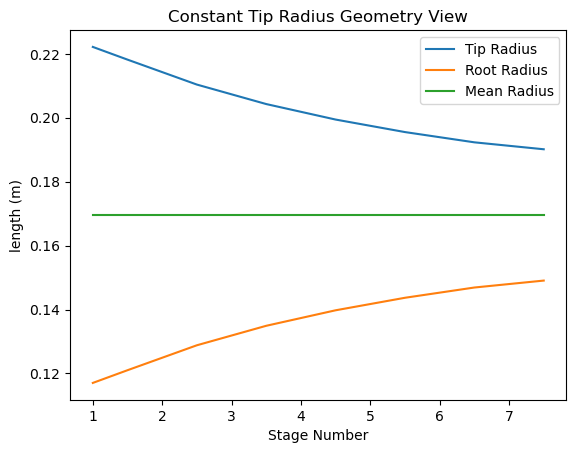

In [141]:
means = [(t+r)/2 for t,r in zip(tips,roots)]
x = np.arange(1,num_stages+0.6,0.5)

plt.figure()
plt.plot(x,tips,label="Tip Radius")
plt.plot(x,roots,label="Root Radius")
plt.plot(x,means,label="Mean Radius")
plt.legend()
plt.xlabel("Stage Number")
plt.ylabel("length (m)")
plt.title("Constant Tip Radius Geometry View")
plt.show()

## Constant Outer Diameter (COD)

$$
\begin{array}{|c|c|}
    \hline
    \text{\textbf{Parameter}} & \text{\textbf{Value}} \\
    \hline
    \text{Inlet stagnation pressure} & 101,325 \, \text{Pa} \\
    \hline
    \text{Inlet stagnation temperature} & 288.15 \, \text{K} \\
    \hline
    \text{Mass flow} & 8.1 \, \text{kg/s} \\
    \hline
    \text{Inlet Mach number} & 0.50 \\
    \hline
    \text{Outlet Mach number} & 0.26 \\
    \hline
    \text{Pressure ratio} & 5.0 \\
    \hline
    \text{Polytropic efficiency} & 89\% \\
    \hline
    \text{Number of stages} & 5 \\
    \hline
    \text{Rotational speed} & 25,650 \, \text{rpm} \\
    \hline
    \text{Inlet hub-tip-ratio} & 0.40 \\
    \hline
    \text{Axial channel} & \text{COD} \\
    \hline
\end{array}
$$

In [31]:
# Input Constraints
takeoff_thrust = 5096
P01 = 1.01325
T01 = 288.15

P_compressor = 5
m_dot = 8.10
turbine_inlet_temperature = 1173

Cp = 1005
gamma = 1.4
R = 287

compressor_polytropic_efficiency = 0.89
n_compressor = -1/(1/compressor_polytropic_efficiency*(gamma-1)/gamma-1)

# Design Variables
N = 25650/60
rr_rt = 0.4
M1 = 0.5
M2 = 0.26

num_stages = 5

### Inlet Axial Flow

Using these specifications, we can start to put together the compressor geometry. However, we need to fix the axial flow of the compressor. To do this, we can solve for the incoming fluid speed, using the inlet mach number.

$$
\begin{aligned}
a_{1} & = \sqrt{\gamma R T_{1}} \\
T_{1} & = T_{01} - \frac{C_1^2}{2C_p} \\
C_{1} & = a_{1} M_{1} \\
          & = \sqrt{\gamma R T_{1}} M_{1} \\
          & = (0.5)\sqrt{1.4(287)(288.15-\frac{C_1^2}{2010})} \\
C_{1} & = 166.0331 \text{ m/s}
\end{aligned}
$$

In [53]:
import sympy as sy

# Solve for the inlet axial velocity (Ca1) based on the Mach number (M1) and the speed of sound (a1)
Ca1 = sy.Symbol("C_a1")
T1 = T01 - (Ca1**2) / (2 * Cp)
a1 = (gamma * R * T1) ** 0.5
C1 = float(sy.solve(M1 * a1 - Ca1, Ca1)[0])
print("Axial Speed 1 =",C1)

# Solve for the outlet axial velocity (Ca2) based on the Mach number (M2) and the speed of sound (a2)
Ca2 = sy.Symbol("C_a2")
T02 = T01 * (P_compressor) ** ((n_compressor - 1) / n_compressor)
T2 = T02 - (Ca2**2) / (2 * Cp)
a2 = (gamma * R * T2) ** 0.5
C2 = float(sy.solve(M2 * a2 - Ca2, Ca2)[0])
print("Axial Speed 2 =",C2)

Axial Speed 1 = 166.03313853492543
Axial Speed 2 = 113.7803139862522


In [54]:
# Calculate the state at the inlet
T1 = T01 - (C1**2) / (2 * Cp)
P1 = P01 * (T1 / T01) ** (gamma / (gamma - 1))
rho1 = P1 / (R * T1) * 100000

# Calculate the inlet geometry
inlet_radius_tip = np.sqrt(m_dot / (np.pi * rho1 * C1 * (1 - rr_rt**2)))
inlet_radius_root = rr_rt * inlet_radius_tip
inlet_radius_mean = (inlet_radius_tip + inlet_radius_root) / 2

# Calculate the state at the outlet
T02 = T01 * (P_compressor) ** ((n_compressor - 1) / n_compressor)
P02 = P_compressor * P01
T2 = T02 - C2**2 / (2 * Cp)
P2 = P02 * (T2 / T02) ** (gamma / (gamma - 1))
rho2 = P2 / (R * T2) * 100000  # Convert to kg/m^3 (assuming P2 is in Pascals and T2 in Kelvin)

# Calculate the area at the outlet (A2) using mass flow rate (m_dot), density (rho2), and axial velocity (C2)
A2 = m_dot / (rho2 * C2)

outlet_radius_tip = inlet_radius_tip
outlet_radius_root = (outlet_radius_tip**2-A2/np.pi)**0.5
outlet_radius_mean = (outlet_radius_tip+outlet_radius_root)/2

print("Geometry:")
print("Inlet")
print("Tip-",inlet_radius_tip)
print("Root-",inlet_radius_root)
print("Mean-",inlet_radius_mean)
print("Outlet")
print("Tip-",outlet_radius_tip)
print("Root-",outlet_radius_root)
print("Mean-",outlet_radius_mean)

Geometry:
Inlet
Tip- 0.13055582635997445
Root- 0.05222233054398978
Mean- 0.09138907845198212
Outlet
Tip- 0.13055582635997445
Root- 0.10311197227059295
Mean- 0.1168338993152837


### Compressor Stages

#### Assuming Linear Root Variance

To advance the compressor design, we need to make an assumption regarding its geometry. For simplicity and feasibility, we will assume that the dimensions of the compressor stages vary linearly along the axis. This linear variation is a common approach that provides a baseline for initial design calculations. While this assumption allows us to proceed with modeling and analysis, alternative methods could potentially yield more accurate or optimized results, especially in cases where non-linear stage variation might better match performance requirements or efficiency goals. Future iterations may explore these options for refinement.

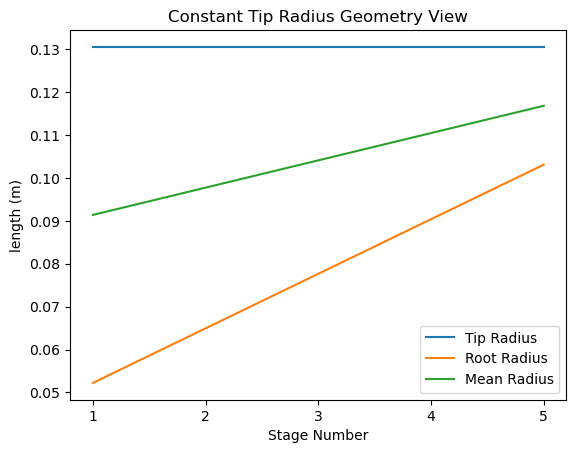

In [55]:
tips = np.linspace(inlet_radius_tip,outlet_radius_tip,num_stages)
roots = np.linspace(inlet_radius_root,outlet_radius_root,num_stages)
means = [(t+r)/2 for t,r in zip(tips,roots)]
U_mean = [2*np.pi*N*m for m in means]

x = range(1,num_stages+1)

plt.figure()
plt.plot(x,tips,label="Tip Radius")
plt.plot(x,roots,label="Root Radius")
plt.plot(x,means,label="Mean Radius")
plt.legend()
plt.xticks(x)
plt.xlabel("Stage Number")
plt.ylabel("length (m)")
plt.title("Constant Tip Radius Geometry View")
plt.show()

In [113]:
# Assuming the work done remains consistent with previous calculations and that the temperature rise varies linearly:

work_done = [max(0.98-i*0.05,0.83) for i in range(num_stages)]
temperature_rise = [(T02-T01)/num_stages for _ in range(num_stages)]

# Assuming that the axial speed varies linearly
C_axial = np.linspace(C1,C2,num_stages)

# Initializing lists for the first stage
C1_swirl = [0]  # Inlet swirl velocity
C2_swirl = [(Cp * temperature_rise[0] / work_done[0] + U_mean[0] * C1_swirl[0]) / U_mean[0]]  # Outlet swirl velocity

# Compute initial flow angles (Beta and Alpha) for the first stage
Beta1 = np.arctan(U_mean[0] / C_axial[0])
Alpha1 = np.arctan(C1_swirl[0] / C_axial[0])
Beta2 = np.arctan((U_mean[0] - C2_swirl[0]) / C_axial[0])
Alpha2 = np.arctan(C2_swirl[0] / C_axial[0])

# Initialize the De Haller factor for the first stage
De_Haller = [np.cos(Beta1) / np.cos(Beta2)]

# Calculate the pressure ratio for the first stage
P_ratio = [(1 + compressor_polytropic_efficiency * temperature_rise[0] / T01) ** (gamma / (gamma - 1))]

# Inlet and Outlet conditions for the first stage
Inlet_P0 = [P01]  # Inlet total pressure
Outlet_P0 = [P_ratio[0] * P01]  # Outlet total pressure

Inlet_T0 = [T01]  # Inlet total temperature
Outlet_T0 = [T01 + temperature_rise[0]]  # Outlet total temperature

# Initialize lambda values for each stage (Lambda[0] for first, 0.5 for others)
Lambda = [1 - (C2_swirl[0] + C1_swirl[0]) / (2 * U_mean[0]), 0.6] + [0.5] * (num_stages - 2)

# Function to calculate beta equations for the flow angles
def beta_equations(x, idx):
    return [
        temperature_rise[idx] * Cp / work_done[idx] / C_axial[idx] / U_mean[idx] - (np.tan(x[0]) - np.tan(x[1])),
        Lambda[idx] / C_axial[idx] * 2 * U_mean[idx] - (np.tan(x[0]) + np.tan(x[1]))
    ]

# Loop through each stage starting from the second stage
for stage_num in range(1, num_stages):
    # Solve the flow angle equations (Beta1 and Beta2) for each stage
    Beta1, Beta2 = fsolve(beta_equations, [1, 1], args=(stage_num,))
    
    # Calculate Alpha1 and Alpha2 based on the flow angles
    Alpha1 = np.arctan(U_mean[stage_num] / C_axial[stage_num] - np.tan(Beta1))
    Alpha2 = np.arctan(U_mean[stage_num] / C_axial[stage_num] - np.tan(Beta2))
    
    # Calculate the swirl velocities for the current stage
    C1_swirl.append(C_axial[stage_num] * np.tan(Alpha1))
    C2_swirl.append(C_axial[stage_num] * np.tan(Alpha2))
    
    # Update De Haller factor for the current stage
    De_Haller.append(np.cos(Beta1) / np.cos(Beta2))
    
    # Calculate the pressure ratio for the current stage
    P_ratio.append((1 + compressor_polytropic_efficiency * temperature_rise[stage_num] / Outlet_T0[-1]) ** (gamma / (gamma - 1)))
    
    # Update total pressures and temperatures for the current stage
    Inlet_P0.append(Outlet_P0[-1])
    Outlet_P0.append(P_ratio[-1] * Inlet_P0[-1])
    Inlet_T0.append(Outlet_T0[-1])
    Outlet_T0.append(Inlet_T0[-1] + temperature_rise[stage_num])

df = {
    "Inlet_T0": Inlet_T0,
    "Outlet_T0": Outlet_T0,
    "Inlet_P0": Inlet_P0,
    "Outlet_P0": Outlet_P0,
    "P_ratio": P_ratio,
    "Axial Vel":C_axial,
    "Inlet_swirl": C1_swirl,
    "Outlet_swirl": C2_swirl,
    "De_Haller": De_Haller
}

df = pd.DataFrame(df)
df.index += 1
df

,Inlet_T0,Outlet_T0,Inlet_P0,Outlet_P0,P_ratio,Axial Vel,Inlet_swirl,Outlet_swirl,De_Haller
1,288.150000,327.133333,1.013250,1.508452,1.488726,166.033139,0.000000,162.857838,0.625782
2,327.133333,366.116666,1.508452,2.146616,1.423059,152.969932,24.802471,185.248165,0.606250
3,366.116666,405.099998,2.146616,2.946985,1.372852,139.906726,60.224091,219.425794,0.585313
4,405.099998,444.083331,2.946985,3.929042,1.333241,126.843520,68.831823,227.904651,0.553305
5,444.083331,483.066664,3.929042,5.112488,1.301205,113.780314,81.705603,232.117461,0.541878


## Lessons Learned

One key insight I've gained is that often, reaching a conclusion requires making certain assumptions along the way.